<a href="https://colab.research.google.com/github/fistki/reinforcement/blob/main/Gridworld_ImprovedDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from IPython.display import clear_output

import copy
import random
from matplotlib import pylab as plt

from collections import deque

# Deep Learning Model

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.nn import functional as F


class ContextBandit:
    def __init__(self, states=10, arms=10):
        self.state = None
        self.bandit_matrix = None
        self.arms = arms
        self.states = states
        self.init_distribution(states, arms)
        self.update_state()

    def init_distribution(self, states, arms):
        self.bandit_matrix = np.random.rand(states, arms)

    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward

    def get_state(self):
        return self.state

    def update_state(self):
        self.state = np.random.randint(0, self.states)

    def get_reward(self, arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])

    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward


class ContextBanditModel(nn.Module):
    def __init__(self, states=10, arms=10, hidden=100):
        super(ContextBanditModel, self).__init__()
        self.states = states
        self.arms = arms
        self.hidden = hidden
        self.l1 = nn.Linear(arms, hidden)
        self.l2 = nn.Linear(hidden, arms)

    def forward(self, x):
        out = F.relu(self.l1(x))
        out = F.relu(self.l2(out))

        return out


class MiniGridModel(nn.Module):
    def __init__(self, l1_input=64, l1_output=150, l2_output=100, output=4):
        super(MiniGridModel, self).__init__()
        self.l1_input = l1_input
        self.l1_output = l1_output
        self.l2_output = l2_output
        self.output = output

        self.l1 = nn.Linear(l1_input, l1_output)
        self.l2 = nn.Linear(l1_output, l2_output)
        self.l3 = nn.Linear(l2_output, output)

    def forward(self, x):
        out = F.relu(self.l1(x))
        out = F.relu(self.l2(out))
        out = self.l3(out)
        return out


class Reinforce(nn.Module):
    def __init__(self):
        super(Reinforce, self).__init__()

        self.agent = nn.Sequential(
            nn.Linear(4, 150),
            nn.LeakyReLU(),
            nn.Linear(150, 2),
            nn.Softmax(dim=0)
        )

    def forward(self, x):
        out = self.agent(x)
        return out


class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(4, 25)
        self.l2 = nn.Linear(25, 50)
        self.actor_lin1 = nn.Linear(50, 2)
        self.l3 = nn.Linear(50, 25)
        self.critic_lin1 = nn.Linear(25, 1)

    def forward(self, x):
        x = F.normalize(x, dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y), dim=0)

        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c))
        return actor, critic


class Genetic(nn.Module):
    def __init__(self):
        super(Genetic, self).__init__()

        self.agent = nn.Sequential(
            nn.Linear(4, 25),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
        )

    def forward(self, x):
        out = self.agent(x)
        out = F.log_softmax(out, dim=0)

        return out

# Utils

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# from JSAnimation.IPython_display import display_animation
from matplotlib import animation
# from IPython.display import HTML
from IPython import display
import torch


def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0][0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i][0])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=10)

    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()


def minigrid_test_model(env, model, mode='static', loss_lim=15, display=True):
    action_set = {
        0: 'u',
        1: 'd',
        2: 'l',
        3: 'r',
    }

    i = 0
    test_game = env(mode=mode)
    state = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state = torch.from_numpy(state).float()

    if display:
        print("Initial State:")
        print(test_game.display())

    status = 1
    while status == 1:
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)
        action = action_set[action_]

        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)

        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state = torch.from_numpy(state_).float()

        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1

        if i > loss_lim:
            if display:
                print("Game lost; too many moves.")
            break

    win = True if status == 2 else False
    return win


def cartpole_train_graph(score):
    score = np.array(score)
    avg_score = running_mean(score, 50)
    plt.figure(figsize=(10, 7))
    plt.ylabel("Episode Duration", fontsize=22)
    plt.xlabel("Training Epochs", fontsize=22)
    plt.plot(avg_score, color='green')


def cartpole_test_scatter(env, model, MAX_DUR=500):
    score = []
    games = 100
    done = False
    state1 = env.reset()
    for i in range(games):
        t = 0
        while not done:
            pred = model(torch.from_numpy(state1).float())
            action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())
            state2, reward, done, truncated = env.step(action)
            state1 = state2
            t += 1
            if t > MAX_DUR:
                break

        state1 = env.reset()
        done = False
        score.append(t)
    score = np.array(score)
    plt.scatter(np.arange(score.shape[0]), score)


def cartpole_test_scatter_a2c(env, model, MAX_DUR=500):
    score = []
    games = 100
    done = False
    state1 = env.reset()

    for i in range(games):
        t = 0
        while not done:
            logits, value = model(torch.from_numpy(state1).float())
            action_dist = torch.distributions.Categorical(logits=logits)
            action = action_dist.sample()
            state2, reward, done, truncated = env.step(action.detach().numpy())
            state1 = state2

            t += 1
            if t > MAX_DUR:
                break

        state1 = env.reset()
        done = False
        score.append(t)

    score = np.array(score)
    plt.scatter(np.arange(score.shape[0]), score)


def cartpole_test_video(env, model, MAX_DUR=500):
    done = False
    frames = []
    t = 0
    state1 = env.reset()
    while not done:
        frames.append(env.render())
        pred = model(torch.from_numpy(state1).float())
        action = np.random.choice(np.array([0, 1]), p=pred.data.numpy())
        state2, reward, done, truncated = env.step(action)
        state1 = state2
        t += 1
        if t > MAX_DUR:  # L
            break

    env.close()
    print(f"Episode length : {t}")

    display_frames_as_gif(frames)


def cartpole_test_video_a2c(env, model, MAX_DUR=500):
    done = False
    frames = []
    t = 0
    state1 = env.reset()

    while not done:
        frames.append(env.render())
        logits, value = model(torch.from_numpy(state1).float())
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample()
        state2, reward, done, truncated = env.step(action.detach().numpy())
        state1 = state2
        t += 1
        if t > MAX_DUR:  # L
            break

    env.close()
    print(f"Episode length : {t}")

    display_frames_as_gif(frames)

# GridWorld

In [ ]:
import numpy as np
import random
import sys

def randPair(s,e):
    return np.random.randint(s,e), np.random.randint(s,e)

class BoardPiece:

    def __init__(self, name, code, pos):
        self.name = name #name of the piece
        self.code = code #an ASCII character to display on the board
        self.pos = pos #2-tuple e.g. (1,4)

class BoardMask:

    def __init__(self, name, mask, code):
        self.name = name
        self.mask = mask
        self.code = code

    def get_positions(self): #returns tuple of arrays
        return np.nonzero(self.mask)

def zip_positions2d(positions): #positions is tuple of two arrays
    x,y = positions
    return list(zip(x,y))

class GridBoard:

    def __init__(self, size=4):
        self.size = size #Board dimensions, e.g. 4 x 4
        self.components = {} #name : board piece
        self.masks = {}

    def addPiece(self, name, code, pos=(0,0)):
        newPiece = BoardPiece(name, code, pos)
        self.components[name] = newPiece

    #basically a set of boundary elements
    def addMask(self, name, mask, code):
        #mask is a 2D-numpy array with 1s where the boundary elements are
        newMask = BoardMask(name, mask, code)
        self.masks[name] = newMask

    def movePiece(self, name, pos):
        move = True
        for _, mask in self.masks.items():
            if pos in zip_positions2d(mask.get_positions()):
                move = False
        if move:
            self.components[name].pos = pos

    def delPiece(self, name):
        del self.components['name']

    def render(self):
        dtype = '<U2'
        displ_board = np.zeros((self.size, self.size), dtype=dtype)
        displ_board[:] = ' '

        for name, piece in self.components.items():
            displ_board[piece.pos] = piece.code

        for name, mask in self.masks.items():
            displ_board[mask.get_positions()] = mask.code

        return displ_board

    def render_np(self):
        num_pieces = len(self.components) + len(self.masks)
        displ_board = np.zeros((num_pieces, self.size, self.size), dtype=np.uint8)
        layer = 0
        for name, piece in self.components.items():
            pos = (layer,) + piece.pos
            displ_board[pos] = 1
            layer += 1

        for name, mask in self.masks.items():
            x,y = self.masks['boundary'].get_positions()
            z = np.repeat(layer,len(x))
            a = (z,x,y)
            displ_board[a] = 1
            layer += 1
        return displ_board

def addTuple(a,b):
    return tuple([sum(x) for x in zip(a,b)])


class Gridworld:

    def __init__(self, size=4, mode='static'):
        if size >= 4:
            self.board = GridBoard(size=size)
        else:
            print("Minimum board size is 4. Initialized to size 4.")
            self.board = GridBoard(size=4)

        #Add pieces, positions will be updated later
        self.board.addPiece('Player','P',(0,0))
        self.board.addPiece('Goal','+',(1,0))
        self.board.addPiece('Pit','-',(2,0))
        self.board.addPiece('Wall','W',(3,0))

        if mode == 'static':
            self.initGridStatic()
        elif mode == 'player':
            self.initGridPlayer()
        else:
            self.initGridRand()

    #Initialize stationary grid, all items are placed deterministically
    def initGridStatic(self):
        #Setup static pieces
        self.board.components['Player'].pos = (0,3) #Row, Column
        self.board.components['Goal'].pos = (0,0)
        self.board.components['Pit'].pos = (0,1)
        self.board.components['Wall'].pos = (1,1)

    #Check if board is initialized appropriately (no overlapping pieces)
    #also remove impossible-to-win boards
    def validateBoard(self):
        valid = True

        player = self.board.components['Player']
        goal = self.board.components['Goal']
        wall = self.board.components['Wall']
        pit = self.board.components['Pit']

        all_positions = [piece for name,piece in self.board.components.items()]
        all_positions = [player.pos, goal.pos, wall.pos, pit.pos]
        if len(all_positions) > len(set(all_positions)):
            return False

        corners = [(0,0),(0,self.board.size), (self.board.size,0), (self.board.size,self.board.size)]
        #if player is in corner, can it move? if goal is in corner, is it blocked?
        if player.pos in corners or goal.pos in corners:
            val_move_pl = [self.validateMove('Player', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            val_move_go = [self.validateMove('Goal', addpos) for addpos in [(0,1),(1,0),(-1,0),(0,-1)]]
            if 0 not in val_move_pl or 0 not in val_move_go:
                #print(self.display())
                #print("Invalid board. Re-initializing...")
                valid = False

        return valid

    #Initialize player in random location, but keep wall, goal and pit stationary
    def initGridPlayer(self):
        #height x width x depth (number of pieces)
        self.initGridStatic()
        #place player
        self.board.components['Player'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridPlayer()

    #Initialize grid so that goal, pit, wall, player are all randomly placed
    def initGridRand(self):
        #height x width x depth (number of pieces)
        self.board.components['Player'].pos = randPair(0,self.board.size)
        self.board.components['Goal'].pos = randPair(0,self.board.size)
        self.board.components['Pit'].pos = randPair(0,self.board.size)
        self.board.components['Wall'].pos = randPair(0,self.board.size)

        if (not self.validateBoard()):
            #print('Invalid grid. Rebuilding..')
            self.initGridRand()

    def validateMove(self, piece, addpos=(0,0)):
        outcome = 0 #0 is valid, 1 invalid, 2 lost game
        pit = self.board.components['Pit'].pos
        wall = self.board.components['Wall'].pos
        new_pos = addTuple(self.board.components[piece].pos, addpos)
        if new_pos == wall:
            outcome = 1 #block move, player can't move to wall
        elif max(new_pos) > (self.board.size-1):    #if outside bounds of board
            outcome = 1
        elif min(new_pos) < 0: #if outside bounds
            outcome = 1
        elif new_pos == pit:
            outcome = 2

        return outcome

    def makeMove(self, action):
        #need to determine what object (if any) is in the new grid spot the player is moving to
        #actions in {u,d,l,r}
        def checkMove(addpos):
            if self.validateMove('Player', addpos) in [0,2]:
                new_pos = addTuple(self.board.components['Player'].pos, addpos)
                self.board.movePiece('Player', new_pos)

        if action == 'u': #up
            checkMove((-1,0))
        elif action == 'd': #down
            checkMove((1,0))
        elif action == 'l': #left
            checkMove((0,-1))
        elif action == 'r': #right
            checkMove((0,1))
        else:
            pass

    def reward(self):
        if (self.board.components['Player'].pos == self.board.components['Pit'].pos):
            return -10
        elif (self.board.components['Player'].pos == self.board.components['Goal'].pos):
            return 10
        else:
            return -1

    def display(self):
        return self.board.render()

# Gridworld check

In [ ]:
# Initial state
game = Gridworld(size=4, mode='static')
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
# Action(move)
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [ ]:
# Reward (case of unterminated state)
print(f"Reward : {game.reward()}")

Reward : -1


In [ ]:
# Express the current state as a frame
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [ ]:
np.shape(game.board.render_np())

(4, 4, 4)

In [ ]:
# action mapping
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

# Step01. DQN without experience replay (static mode)

In [ ]:
# l1_input = state , output = Q value of action
model = MiniGridModel(l1_input=64, l1_output=150, l2_output=100, output=4)
model

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# gamma = discount factor
gamma = 0.9
# epsilon = epsilon greedy policy parameter
epsilon = 1.0

In [ ]:
epochs = 500 # 2000
losses = []
for i in range(epochs):
    game = Gridworld(size=4, mode='static')
    current_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    current_state = torch.from_numpy(current_state).float()

    # status == 1 : Unterminated status
    status = 1

    while status == 1:
        q_value = model(current_state)

        # Policy (Epsilon greedy)
        if random.random() < epsilon:
            action_idx = np.random.randint(0,4)
        else:
            action_idx = torch.argmax(q_value).item()

        # Action mapping
        action = action_set[action_idx]
        game.makeMove(action)

        # Next state
        next_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        next_state = torch.from_numpy(next_state).float()
        reward = game.reward()

        # Target Q value
        with torch.no_grad():
            newQ = model(next_state.reshape(1,64))
        maxQ = torch.max(newQ)

        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward

        Y = torch.Tensor([Y]).detach()
        X = q_value.squeeze()[action_idx]
        loss = loss_fn(X, Y)

        print(i, loss.item())

        clear_output(wait=True)

        # Q value Update
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        current_state = next_state

        # Terminated condition
        if reward != -1:
            status = 0

    if epsilon > 0.1:
        epsilon -= (1/epochs)

499 0.00025267782621085644


Text(0, 0.5, 'Loss')

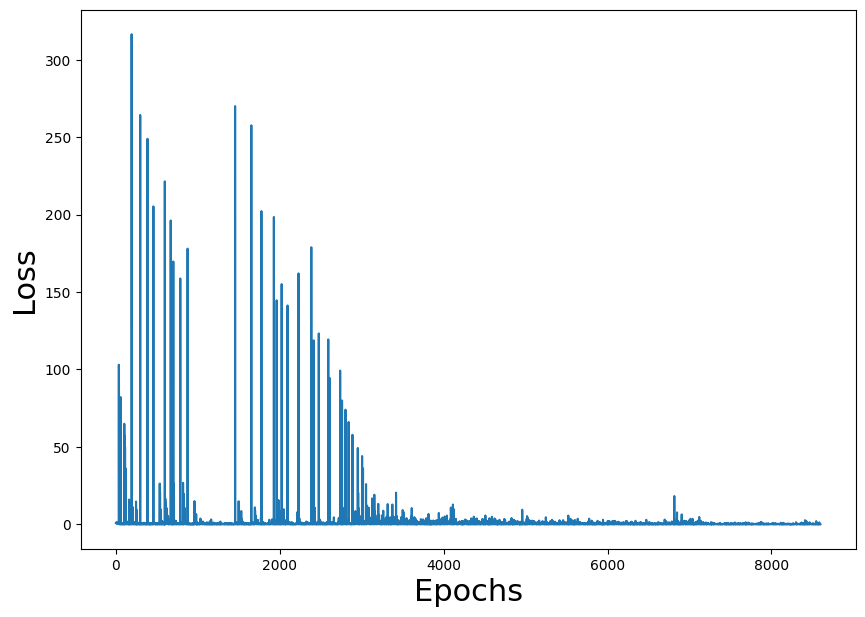

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
minigrid_test_model(Gridworld, model, mode='static', loss_lim=15)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[['+' '-' 'P' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

In [ ]:
max_games = 500 # 1000
wins = 0
for i in range(max_games):
    win = minigrid_test_model(Gridworld, model, mode='static', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 500, # of wins: 500
Win percentage: 100.0%


# Step2. DQN without replay buffer (random mode)

In [ ]:
model = MiniGridModel(l1_input=64, l1_output=150, l2_output=100, output=4)
model

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# gamma = discount factor
gamma = 0.9
# epsilon = epsilon greedy policy parameter
epsilon = 1.0

In [ ]:
epochs = 500 # 2000
losses = []
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    current_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    current_state = torch.from_numpy(current_state).float()

    # status == 1 : Unterminated status
    status = 1

    while status == 1:
        q_value = model(current_state)

        # Policy (Epsilon greedy)
        if random.random() < epsilon:
            action_idx = np.random.randint(0,4)
        else:
            action_idx = torch.argmax(q_value).item()

        # Action mapping
        action = action_set[action_idx]
        game.makeMove(action)

        # Next state
        next_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        next_state = torch.from_numpy(next_state).float()
        reward = game.reward()

        # Target Q value
        with torch.no_grad():
            newQ = model(next_state.reshape(1,64))
        maxQ = torch.max(newQ)

        if reward == -1:
            Y = reward + (gamma * maxQ)
        else:
            Y = reward

        Y = torch.Tensor([Y]).detach()
        X = q_value.squeeze()[action_idx]
        loss = loss_fn(X, Y)

        print(i, loss.item())

        clear_output(wait=True)

        # Q value Update
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        current_state = next_state

        # Terminated condition
        if reward != -1:
            status = 0

    if epsilon > 0.1:
        epsilon -= (1/epochs)

499 22.422069549560547


Text(0, 0.5, 'Loss')

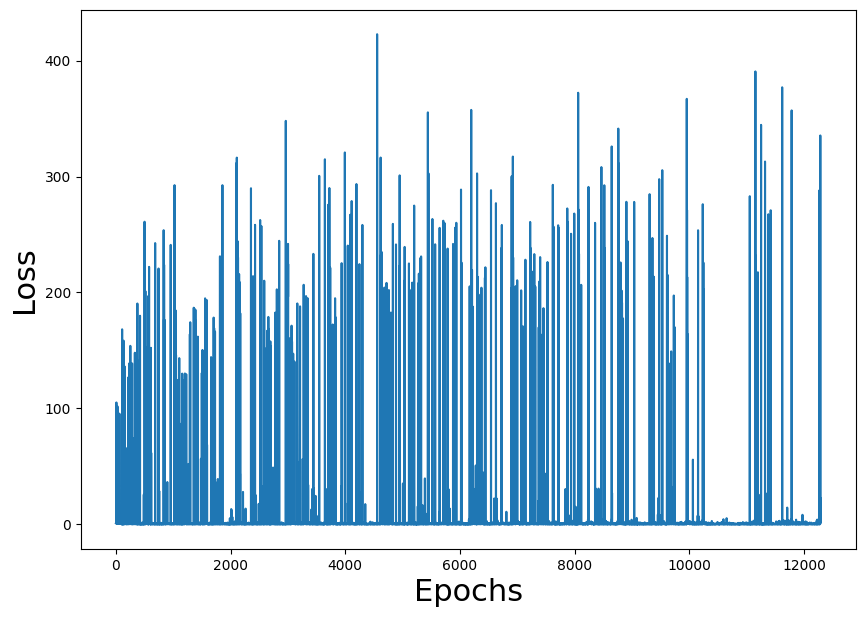

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
max_games = 500 # 2000
wins = 0
for i in range(max_games):
    win = minigrid_test_model(Gridworld, model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 500, # of wins: 112
Win percentage: 22.400000000000002%


# Step3. DQN with replay buffer (Experience replay)

In [ ]:
model = MiniGridModel(l1_input=64, l1_output=150, l2_output=100, output=4)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [ ]:
epochs = 500 # 2000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0

    while status == 1:
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False

        exp =  (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2


        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M

            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())

            print(i, loss.item())
            clear_output(wait=True)

            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0

losses = np.array(losses)

499 0.2849096357822418


Text(0, 0.5, 'Loss')

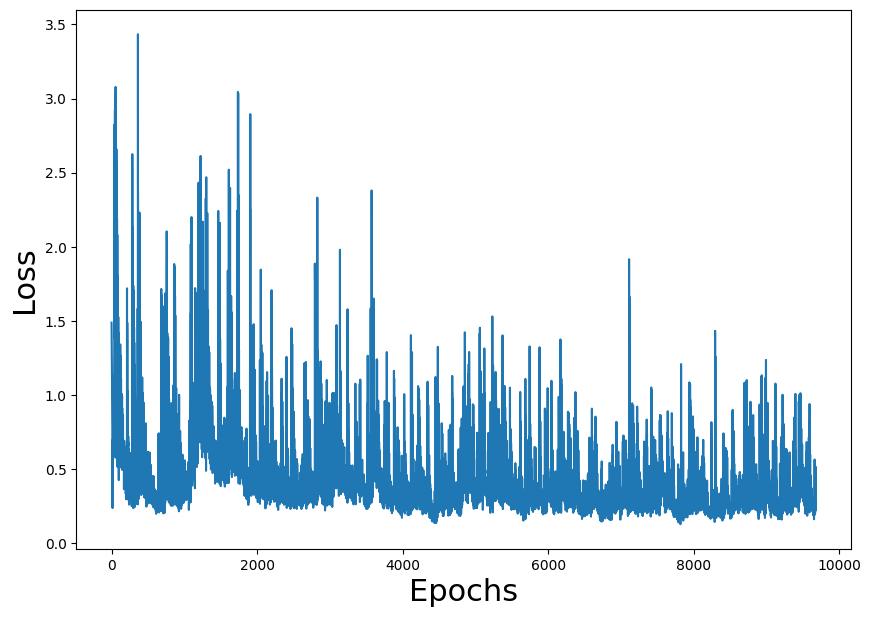

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
max_games = 500 # 1000
wins = 0
for i in range(max_games):
    win = minigrid_test_model(Gridworld, model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 500, # of wins: 216
Win percentage: 43.2%


# Step4. Using target Net

In [ ]:
model = MiniGridModel(l1_input=64, l1_output=150, l2_output=100, output=4)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

target_model = copy.deepcopy(model)
target_model.load_state_dict(model.state_dict())

epochs = 500 # 2000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0

# Frequency of sync
sync_freq = 200
j=0

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    current_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    current_state = torch.from_numpy(current_state).float()
    status = 1
    mov = 0

    while status == 1:
        j+=1
        mov += 1
        qval = model(current_state)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        next_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        next_state = torch.from_numpy(next_state).float()
        reward = game.reward()
        done = True if reward > 0 else False

        exp =  (current_state, action_, reward, next_state, done)
        replay.append(exp)
        current_state = next_state

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = target_model(state2_batch)

            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            if j % sync_freq == 0:
                target_model.load_state_dict(model.state_dict())

        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0

losses = np.array(losses)


<All keys matched successfully>

In [ ]:
epochs = 500 # 2000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0

# Frequency of sync
sync_freq = 200
j=0

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    current_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    current_state = torch.from_numpy(current_state).float()
    status = 1
    mov = 0

    while status == 1:
        j+=1
        mov += 1
        qval = model(current_state)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        next_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        next_state = torch.from_numpy(next_state).float()
        reward = game.reward()
        done = True if reward > 0 else False

        exp =  (current_state, action_, reward, next_state, done)
        replay.append(exp)
        current_state = next_state

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = target_model(state2_batch)

            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            if j % sync_freq == 0:
                target_model.load_state_dict(model.state_dict())

        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0

losses = np.array(losses)


499 0.18385612964630127


In [ ]:
epochs = 500 # 2000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0

# Frequency of sync
sync_freq = 200
j=0

for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    current_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    current_state = torch.from_numpy(current_state).float()
    status = 1
    mov = 0

    while status == 1:
        j+=1
        mov += 1
        qval = model(current_state)
        qval_ = qval.data.numpy()

        if random.random() < epsilon:
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)

        action = action_set[action_]
        game.makeMove(action)
        next_state = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        next_state = torch.from_numpy(next_state).float()
        reward = game.reward()
        done = True if reward > 0 else False

        exp =  (current_state, action_, reward, next_state, done)
        replay.append(exp)
        current_state = next_state

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = target_model(state2_batch)

            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            if j % sync_freq == 0:
                target_model.load_state_dict(model.state_dict())

        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0

losses = np.array(losses)


499 0.0918092131614685


Text(0, 0.5, 'Loss')

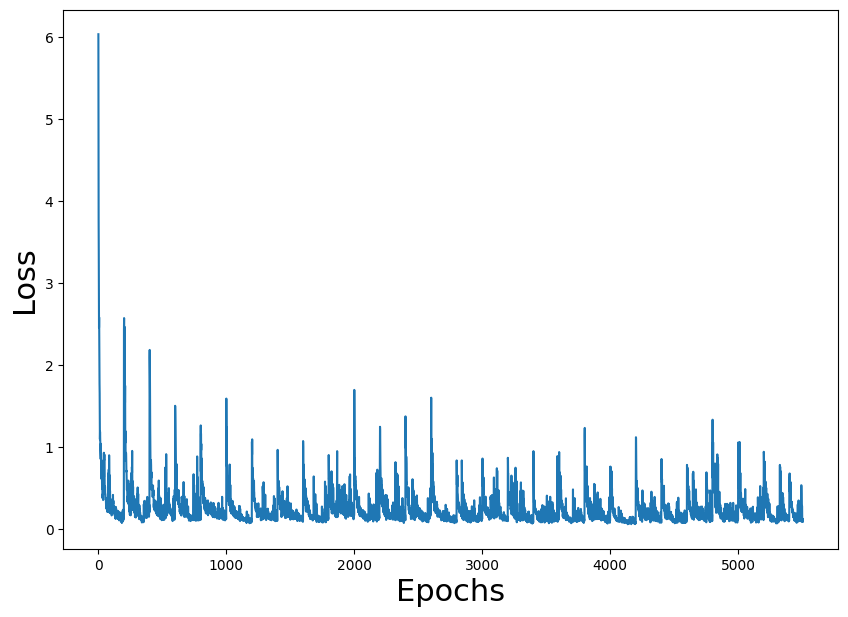

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)


In [ ]:
max_games = 500 # 1000
wins = 0
for i in range(max_games):
    win = minigrid_test_model(Gridworld, model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 500, # of wins: 304
Win percentage: 60.8%
